# Credit Default Prediction with Logistic Regression

This notebook implements a logistic regression model to predict credit defaults based on various customer features.

# import libraries

In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Loading and Exploring the Dataset

In [12]:
# Load the dataset
df = pd.read_csv('cleaned_data/balanced_training_set_70percent.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Display basic statistics
print("\nBasic statistics:")
print(df.describe())

# Display data types
print("\nData types:")
print(df.dtypes)

Dataset shape: (21474, 20)

First 5 rows of the dataset:
        ID  label CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5106137      0           M             1                1             0   
1  5022875      1           F             1                1             2   
2  5010390      1           F             1                1             0   
3  5145979      1           F             1                0             0   
4  5061622      1           M             1                1             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          126000.0               Working  Secondary / secondary special   
1          225000.0  Commercial associate               Higher education   
2          540000.0  Commercial associate               Higher education   
3          112500.0         State servant  Secondary / secondary special   
4          427500.0         State servant              Incomplete higher   

     NAME_FAMILY_

# Data Preprocessing

Target variable distribution:
label
1    18326
0     3148
Name: count, dtype: int64
Target variable distribution percentage:
label
1    85.340412
0    14.659588
Name: proportion, dtype: float64


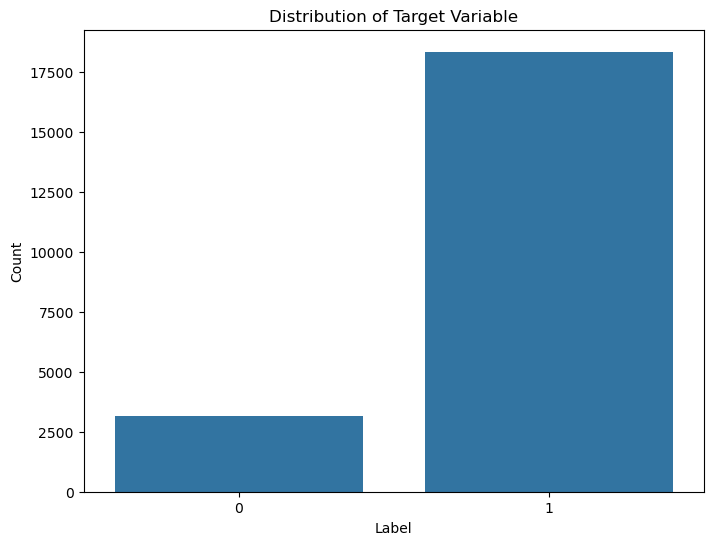


Shape of X after preprocessing: (21474, 43)
Number of features: 43


In [13]:
# Separate the target variable and features
X = df.drop('label', axis=1)  # Assuming 'label' is the target variable
y = df['label']

# Check the distribution of the target variable
print("Target variable distribution:")
print(y.value_counts())
print(f"Target variable distribution percentage:\n{y.value_counts(normalize=True) * 100}")

# Plot the target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y)
plt.title('Distribution of Target Variable')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Drop unnecessary columns (ID is not needed for modeling)
if 'ID' in X.columns:
    X = X.drop('ID', axis=1)

# Convert categorical variables to dummy variables
categorical_columns = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

print(f"\nShape of X after preprocessing: {X.shape}")
print(f"Number of features: {X.shape[1]}")

# Feature Scaling and Dimensionality Reduction with PCA

Training set shape: (15031, 43)
Testing set shape: (6443, 43)


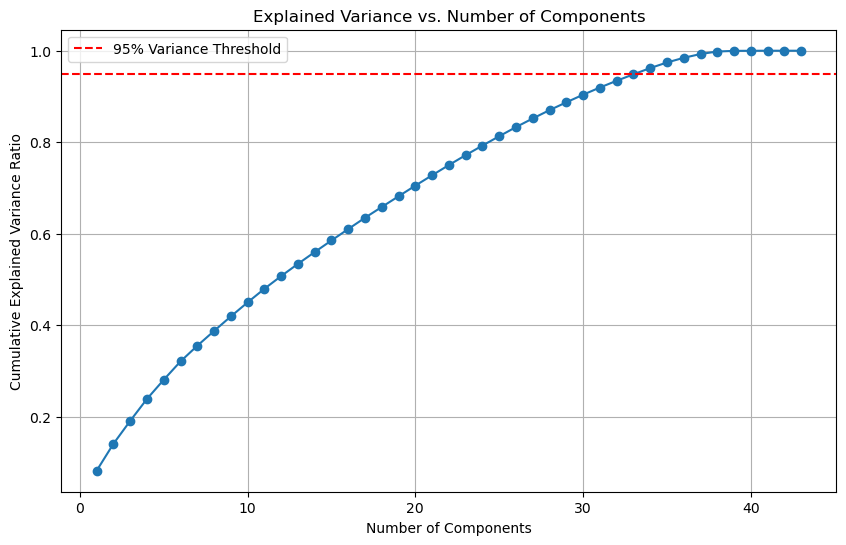

Number of components needed to explain 95% of the variance: 34
Shape of X_train_pca: (15031, 34)
Shape of X_test_pca: (6443, 34)


In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Create a pipeline with standardization, PCA, and logistic regression
# We'll determine the optimal number of components for PCA
pca = PCA()
scaler = StandardScaler()

# Apply scaling to the data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit PCA to determine the optimal number of components
pca.fit(X_train_scaled)

# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.legend()
plt.show()

# Find the number of components needed to explain 95% of the variance
n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Number of components needed to explain 95% of the variance: {n_components}")

# Apply PCA with the selected number of components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Shape of X_train_pca: {X_train_pca.shape}")
print(f"Shape of X_test_pca: {X_test_pca.shape}")

# Building and Training the Logistic Regression Model

In [15]:
# Create a logistic regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Define the parameter grid for grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Train the model with the best parameters
best_model.fit(X_train_pca, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test_pca)
y_pred_proba = best_model.predict_proba(X_test_pca)[:, 1]

Best parameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}
Best cross-validation score: 0.9353


# Model Evaluation

Optimal threshold: 0.8520

=== Default Threshold (0.5) ===
Accuracy: 0.8802
Precision: 0.8769
Recall: 1.0000
Specificity: 0.1831
F1 score: 0.9344
ROC-AUC: 0.6937
PR-AUC: 0.9214

Confusion Matrix (Default):
[[ 173  772]
 [   0 5498]]

=== Optimized Threshold (0.8520) ===
Accuracy: 0.7157
Precision: 0.9020
Recall: 0.7481
Specificity: 0.5270
F1 score: 0.8179

Confusion Matrix (Optimized):
[[ 498  447]
 [1385 4113]]


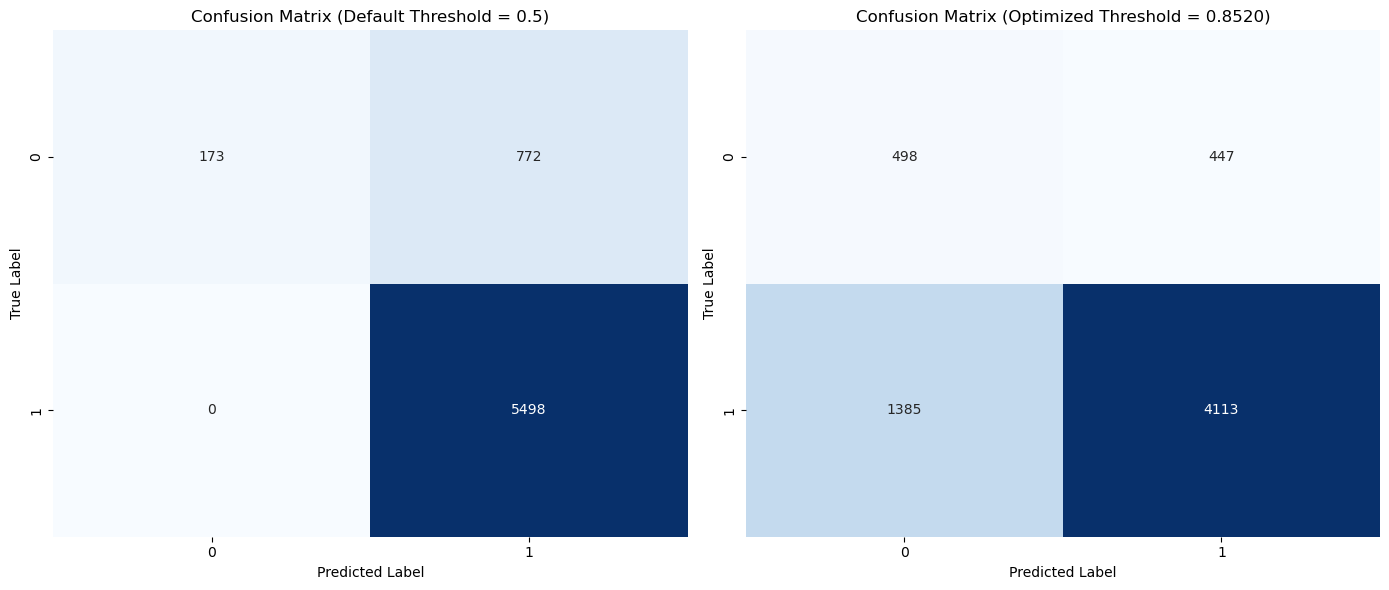

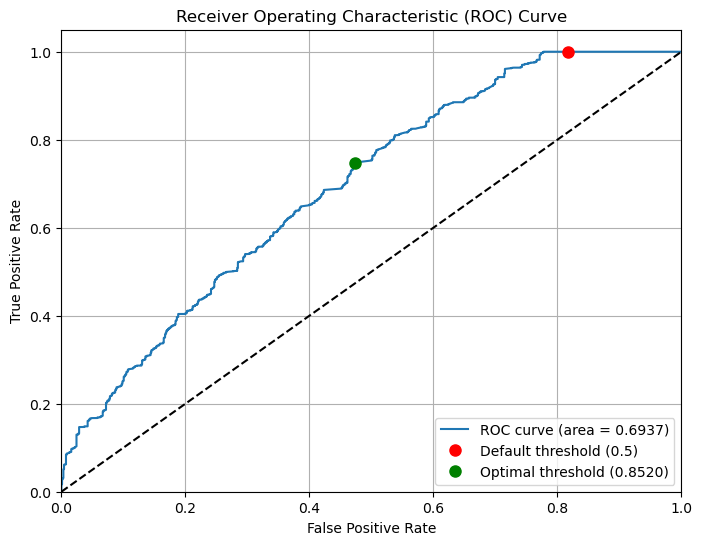

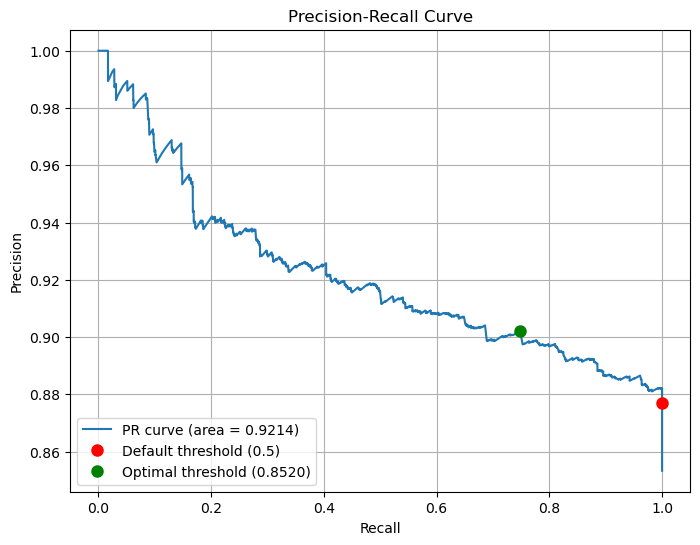

In [16]:
# Calculate predicted probabilities
y_pred_proba = best_model.predict_proba(X_test_pca)[:, 1]

# Find optimal threshold using ROC curve
from sklearn.metrics import roc_curve, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold:.4f}")

# Predictions
y_pred_default = (y_pred_proba >= 0.5).astype(int)
y_pred_optimized = (y_pred_proba >= optimal_threshold).astype(int)

# Default metrics
accuracy_default = accuracy_score(y_test, y_pred_default)
precision_default = precision_score(y_test, y_pred_default)
recall_default = recall_score(y_test, y_pred_default)
specificity_default = recall_score(y_test, y_pred_default, pos_label=0)
f1_default = f1_score(y_test, y_pred_default)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# PR-AUC
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall_curve, precision_curve)

# Optimized metrics
accuracy_opt = accuracy_score(y_test, y_pred_optimized)
precision_opt = precision_score(y_test, y_pred_optimized)
recall_opt = recall_score(y_test, y_pred_optimized)
specificity_opt = recall_score(y_test, y_pred_optimized, pos_label=0)
f1_opt = f1_score(y_test, y_pred_optimized)

# Confusion matrices
cm_default = confusion_matrix(y_test, y_pred_default)
cm_opt = confusion_matrix(y_test, y_pred_optimized)

# Print evaluation metrics
print("\n=== Default Threshold (0.5) ===")
print(f"Accuracy: {accuracy_default:.4f}")
print(f"Precision: {precision_default:.4f}")
print(f"Recall: {recall_default:.4f}")
print(f"Specificity: {specificity_default:.4f}")
print(f"F1 score: {f1_default:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print("\nConfusion Matrix (Default):")
print(cm_default)

print(f"\n=== Optimized Threshold ({optimal_threshold:.4f}) ===")
print(f"Accuracy: {accuracy_opt:.4f}")
print(f"Precision: {precision_opt:.4f}")
print(f"Recall: {recall_opt:.4f}")
print(f"Specificity: {specificity_opt:.4f}")
print(f"F1 score: {f1_opt:.4f}")
print("\nConfusion Matrix (Optimized):")
print(cm_opt)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Confusion Matrix (Default Threshold = 0.5)')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_title(f'Confusion Matrix (Optimized Threshold = {optimal_threshold:.4f})')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

# ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')

default_idx = np.argmin(np.abs(thresholds - 0.5))
plt.plot(fpr[default_idx], tpr[default_idx], 'ro', markersize=8, label='Default threshold (0.5)')
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'go', markersize=8, label=f'Optimal threshold ({optimal_threshold:.4f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, label=f'PR curve (area = {pr_auc:.4f})')

# Mark default and optimal threshold points on PR curve
threshold_indices = []
for threshold in [0.5, optimal_threshold]:
    y_pred = (y_pred_proba >= threshold).astype(int)
    p = precision_score(y_test, y_pred)
    r = recall_score(y_test, y_pred)
    distances = np.sqrt((precision_curve - p)**2 + (recall_curve - r)**2)
    closest_idx = np.argmin(distances)
    threshold_indices.append(closest_idx)

plt.plot(recall_curve[threshold_indices[0]], precision_curve[threshold_indices[0]], 'ro', markersize=8,
         label='Default threshold (0.5)')
plt.plot(recall_curve[threshold_indices[1]], precision_curve[threshold_indices[1]], 'go', markersize=8,
         label=f'Optimal threshold ({optimal_threshold:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


Feature Importance Analysis

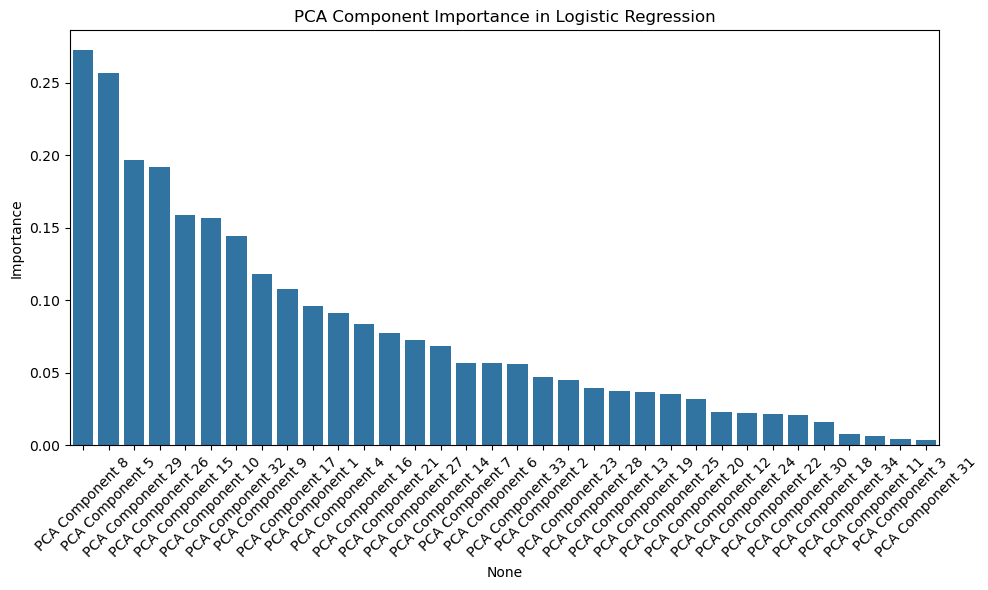


Top 10 features in PCA Component 8:
NAME_INCOME_TYPE_Pensioner                           0.328066
FLAG_PHONE                                           0.315722
OCCUPATION_TYPE_Low-skill Laborers                   0.291862
NAME_EDUCATION_TYPE_Lower secondary                  0.279848
OCCUPATION_TYPE_IT staff                             0.261231
NAME_INCOME_TYPE_Student                             0.251289
NAME_EDUCATION_TYPE_Secondary / secondary special    0.227798
NAME_FAMILY_STATUS_Separated                         0.225429
NAME_FAMILY_STATUS_Single / not married              0.205217
Grouped_Housing_Type_Other                           0.196700
Name: 0, dtype: float64


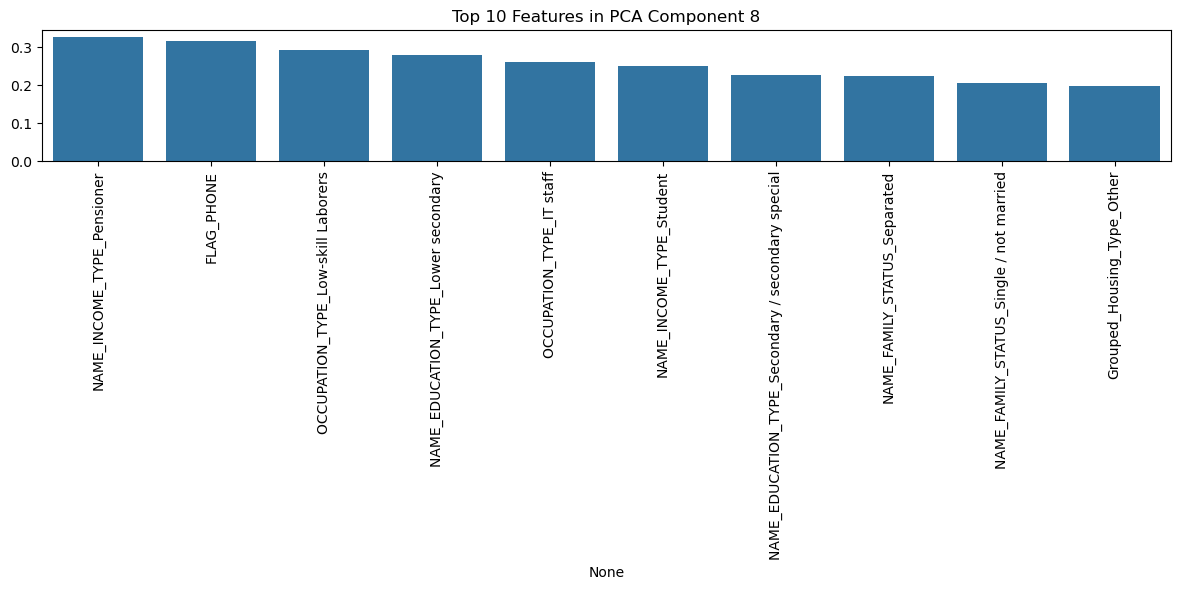


Top 10 features in PCA Component 5:
FLAG_WORK_PHONE                                      0.415565
FLAG_OWN_REALTY                                      0.338030
Grouped_Housing_Type_Other                           0.270230
NAME_EDUCATION_TYPE_Secondary / secondary special    0.264034
NAME_INCOME_TYPE_Pensioner                           0.262460
NAME_FAMILY_STATUS_Single / not married              0.231976
NAME_FAMILY_STATUS_Separated                         0.219746
NAME_EDUCATION_TYPE_Incomplete higher                0.207662
NAME_EDUCATION_TYPE_Lower secondary                  0.203164
NAME_INCOME_TYPE_State servant                       0.201692
Name: 1, dtype: float64


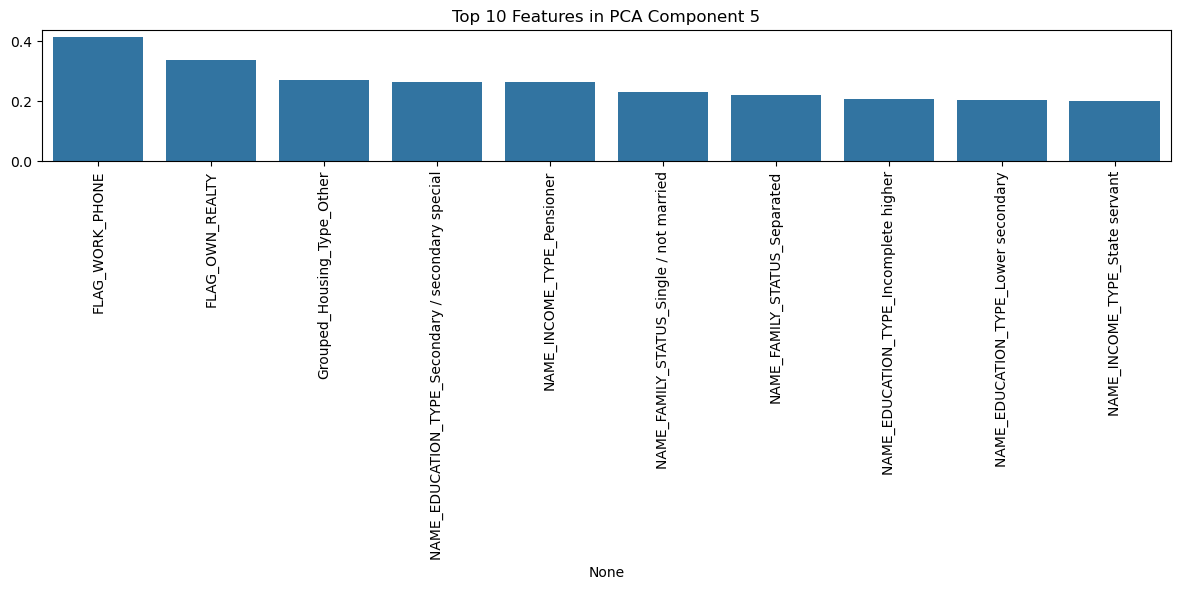


Top 10 features in PCA Component 29:
NAME_INCOME_TYPE_Pensioner                 0.399884
NAME_FAMILY_STATUS_Widow                   0.341687
OCCUPATION_TYPE_Low-skill Laborers         0.333031
OCCUPATION_TYPE_IT staff                   0.268001
AGE                                        0.251931
DAYS_BIRTH                                 0.249554
FLAG_OWN_CAR                               0.247543
NAME_EDUCATION_TYPE_Incomplete higher      0.241818
FLAG_OWN_REALTY                            0.228100
NAME_FAMILY_STATUS_Single / not married    0.190905
Name: 2, dtype: float64


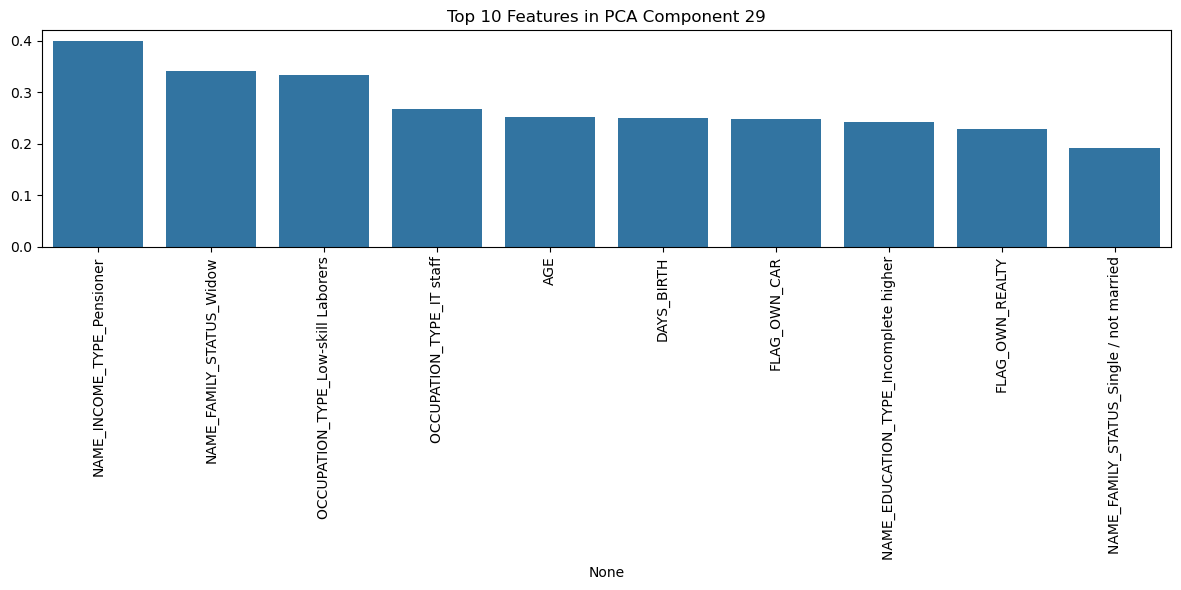

In [17]:
# Analyze the importance of PCA components in the logistic regression model
pca_feature_importance = pd.DataFrame(
    abs(best_model.coef_[0]),
    index=[f'PCA Component {i+1}' for i in range(n_components)],
    columns=['Importance']
)

# Sort by importance
pca_feature_importance = pca_feature_importance.sort_values('Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=pca_feature_importance.index, y='Importance', data=pca_feature_importance)
plt.title('PCA Component Importance in Logistic Regression')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze the original features' contribution to the top PCA components
top_n_components = 3  # Adjust based on your results
top_components_idx = pca_feature_importance.index[:top_n_components].str.extract(r'(\d+)').astype(int).iloc[:, 0] - 1

# Get the loading scores for the top components
loading_scores = pd.DataFrame(
    pca.components_[top_components_idx, :],
    columns=X.columns
)

# Display the top features for each important component
for i, component_idx in enumerate(top_components_idx):
    component_name = f'PCA Component {component_idx + 1}'
    print(f"\nTop 10 features in {component_name}:")
    
    # Sort features by absolute loading scores
    sorted_loadings = loading_scores.iloc[i, :].abs().sort_values(ascending=False)
    print(sorted_loadings.head(10))
    
    # Plot the top features for this component
    plt.figure(figsize=(12, 6))
    top_10_loadings = sorted_loadings.head(10)
    sns.barplot(x=top_10_loadings.index, y=top_10_loadings.values)
    plt.title(f'Top 10 Features in {component_name}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()